In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("../data/Olympic_Swimming_Results_1912to2020.csv")

df

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
0,Tokyo,2020,100m,Backstroke,0,Men,ROC,Evgeny Rylov,51.98,1
1,Tokyo,2020,100m,Backstroke,0,Men,ROC,Kliment Kolesnikov,52,2
2,Tokyo,2020,100m,Backstroke,0,Men,USA,Ryan Murphy,52.19,3
3,Tokyo,2020,100m,Backstroke,0,Men,ITA,Thomas Ceccon,52.3,4
4,Tokyo,2020,100m,Backstroke,0,Men,CHN,Jiayu Xu,52.51,4
...,...,...,...,...,...,...,...,...,...,...
4354,Stockholm,1912,4x100,Freestyle,1,Women,SWE,"Greta Carlsson, Vera Thulin, Sonja Johnsson, G...",NaN,5
4355,Stockholm,1912,4x200,Freestyle,1,Men,AUS,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",00:10:11.200000,1
4356,Stockholm,1912,4x200,Freestyle,1,Men,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",00:10:20.200000,2
4357,Stockholm,1912,4x200,Freestyle,1,Men,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",00:10:28.600000,3


Basic EDA

In [191]:
df.isnull().sum()

Location                 0
Year                     0
Distance (in meters)     0
Stroke                   0
Relay?                   0
Gender                   0
Team                     0
Athlete                 14
Results                 28
Rank                     0
dtype: int64

In [192]:
df.describe()

,Year,Relay?,Rank
count,4359.000000,4359.000000,4359.000000
mean,1982.936453,0.169764,3.164946
std,26.928344,0.375468,1.189715
min,1912.000000,0.000000,0.000000
25%,1968.000000,0.000000,2.000000
50%,1988.000000,0.000000,4.000000
75%,2004.000000,0.000000,4.000000
max,2020.000000,1.000000,5.000000


In [193]:
df.dtypes

Location                object
Year                     int64
Distance (in meters)    object
Stroke                  object
Relay?                   int64
Gender                  object
Team                    object
Athlete                 object
Results                 object
Rank                     int64
dtype: object

In [194]:
df = df[df['Relay?'] == 0]
df = df.drop(columns=["Location"])
df["Event"] = df["Distance (in meters)"].astype(str) + " " + df["Stroke"]
df = df.drop(columns=["Distance (in meters)", "Stroke", "Relay?"])

cols = df.columns.tolist()
cols.insert(cols.index("Year") + 1, cols.pop(cols.index("Event")))
df = df[cols]

df = df.dropna()
df = df[df["Results"].str.lower() != "did not finish"]

df = df.reset_index(drop=True)

In [195]:
def parse_swim_time(x):
    """Convert messy swim times into total seconds (float)."""
    s = str(x).strip()

    # Case 1: plain numbers like 51.98, 52, 52.123
    try:
        return float(s)
    except ValueError:
        pass
    
    # Case 2: colon-separated formats (m:ss.ms, mm:ss.ms, hh:mm:ss.msssss)
    parts = s.split(":")
    try:
        parts = [float(p) for p in parts]
        if len(parts) == 3: # hh:mm:ss.ms
            h, m, sec = parts
            return h*3600 + m*60 + sec
        elif len(parts) == 2: # mm:ss.ms or m:ss.ms
            m, sec = parts
            return m*60 + sec
    except:
        return None
    
    return None

def format_mm_ss_ms(sec):
    """Convert seconds into mm:ss.ms format (standard style)"""
    minutes = int(sec // 60)
    seconds = sec % 60
    return f"{minutes:02d}:{seconds:05.2f}"

# Apply to dataframe
df["Results_seconds"] = df["Results"].apply(parse_swim_time)
df = df.dropna(subset=["Results_seconds"]) # Remove bad rows
df["Results"] = df["Results_seconds"].apply(format_mm_ss_ms)

In [196]:
df

,Year,Event,Gender,Team,Athlete,Results,Rank,Results_seconds
0,2020,100m Backstroke,Men,ROC,Evgeny Rylov,00:51.98,1,51.98
1,2020,100m Backstroke,Men,ROC,Kliment Kolesnikov,00:52.00,2,52.00
2,2020,100m Backstroke,Men,USA,Ryan Murphy,00:52.19,3,52.19
3,2020,100m Backstroke,Men,ITA,Thomas Ceccon,00:52.30,4,52.30
4,2020,100m Backstroke,Men,CHN,Jiayu Xu,00:52.51,4,52.51
...,...,...,...,...,...,...,...,...
3565,1912,400m Freestyle,Men,CAN,George Ritchie Hodgson,05:24.40,1,324.40
3566,1912,400m Freestyle,Men,GBR,John Gatenby Hatfield,05:25.80,2,325.80
3567,1912,400m Freestyle,Men,ANZ,Harold H. Hardwick,05:31.20,3,331.20
3568,1912,400m Freestyle,Men,ANZ,Cecil Healy,05:37.80,4,337.80


In [197]:
df["Year"].dtype

dtype('int64')

df["Year"] = pd.to_datetime(df["Year"].astype(str), format="%Y")mm
df["Year"] = df["Year"].dt.to_period("Y")

df["Year"].dtype

In [198]:
summary = (
    df.groupby(["Year", "Event", "Gender"])["Results_seconds"]
      .mean()
      .reset_index()
      .rename(columns={"Results_seconds": "Avg_Results_seconds"})
)
summary["Avg_Results"] = summary["Avg_Results_seconds"].apply(format_mm_ss_ms)

summary.to_csv("event_year_summary.txt", sep='\t', index=False)


In [199]:
summary

,Year,Event,Gender,Avg_Results_seconds,Avg_Results
0,1912,100m Backstroke,Men,83.720000,01:23.72
1,1912,100m Freestyle,Men,65.160000,01:05.16
2,1912,100m Freestyle,Women,85.840000,01:25.84
3,1912,1500m Freestyle,Men,1358.133333,22:38.13
4,1912,200m Breaststroke,Men,185.900000,03:05.90
...,...,...,...,...,...
448,2020,400m Individual medley,Men,250.620000,04:10.62
449,2020,50m Freestyle,Men,21.600000,00:21.60
450,2020,50m Freestyle,Women,24.225000,00:24.23
451,2020,800m Freestyle,Men,465.193750,07:45.19


/var/folders/js/5_z053qd0wnbty96_lsy0cgh0000gn/T/ipykernel_30474/3510706952.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data["Year"] = event_data["Year"].astype(int)


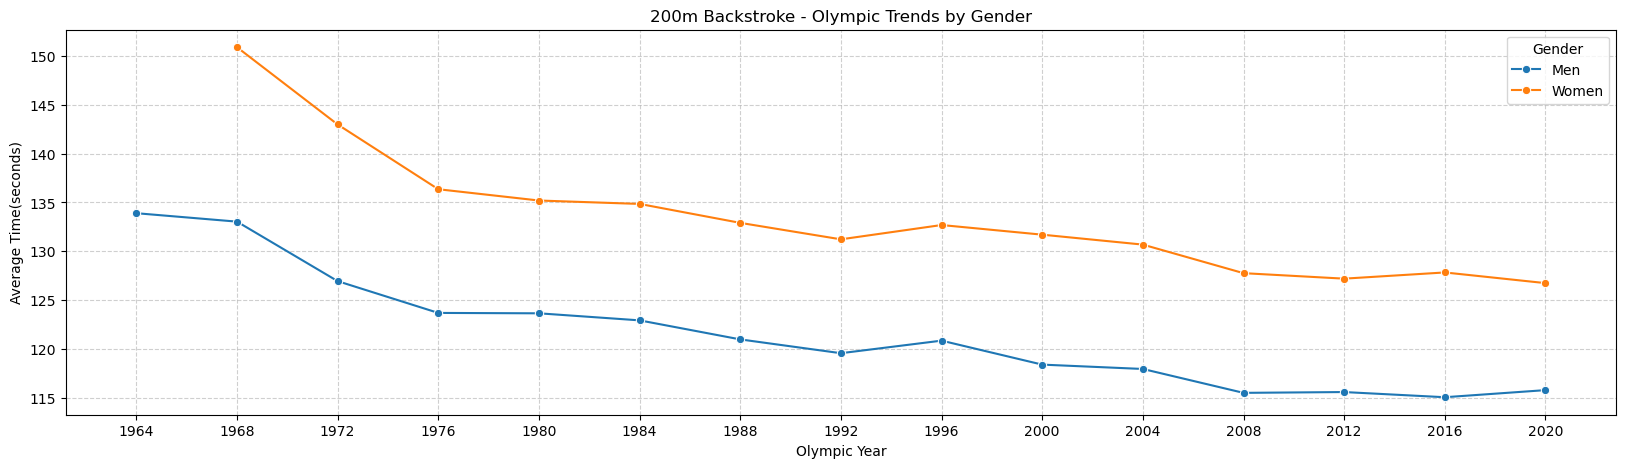

In [200]:
event_to_plot = "200m Backstroke"

# Filter dataset for that event
event_data = summary[summary["Event"] == event_to_plot]

# Convert year (Period) to integer for plotting
event_data["Year"] = event_data["Year"].astype(int)


# Plot
plt.figure(figsize=(20,5))
sns.lineplot(
    data=event_data,
    x="Year",
    y="Avg_Results_seconds",
    hue="Gender",
    marker="o"
)

plt.title(f"{event_to_plot} - Olympic Trends by Gender")
plt.ylabel("Average Time(seconds)")
plt.xlabel("Olympic Year")
plt.xticks(event_data["Year"].unique())
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [201]:
event_data["Year"].dtype

dtype('int64')

/var/folders/js/5_z053qd0wnbty96_lsy0cgh0000gn/T/ipykernel_30474/3157320469.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_range = np.arange(min(x), max(x) + 8, 4).reshape(-1,1)


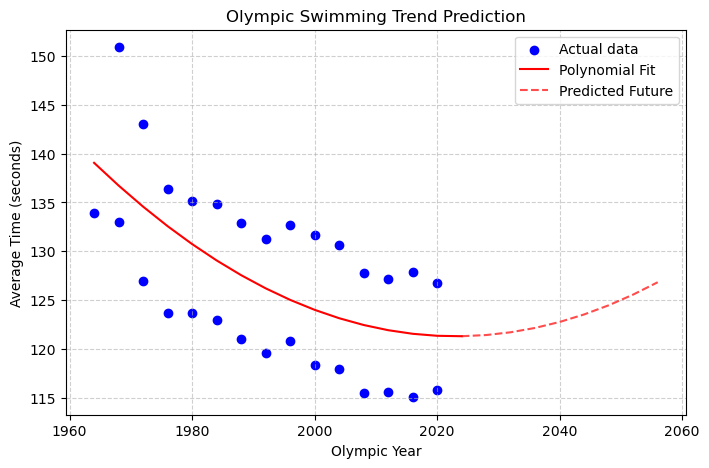

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

event_to_plot = "200m Backstroke"

# Filter dataset for that event
event_data = summary[summary["Event"] == event_to_plot].copy()
event_data["Year"] = event_data["Year"].astype(int)

plt.figure(figsize=(10,6))

# Loop through both genders
for gender in event_data["Gender"].unique():
    gender_data = event_data[event_data["Gender"] == gender]

    x = np.array(gender_data["Year"]).reshape(-1,1)
    y = gender_data["Avg_Results_seconds"].values

    # Polynomial regression
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    model = LinearRegression().fit(x_poly, y)

    # Predict historical range
    x_range = np.arange(min(x)), max(x)+8, 4).reshape(-1,1)
    x_range_poly = 